# Progetto MOBD 2022
## Valerio Famoso 0299845 - Tiziano Taglienti 0304926

Lo svolgimento del progetto comprende una fase di lettura del dataset fornito (file *train.csv*) e del test set che verrà usato per la valutazione.

La fase di preprocessing comprenderà pulizia e riorganizzazione del training set.

Infine viene illustrata la routine di addestramento che, durante la fase di implementazione, ha fornito risultati migliori. Sono stati impostati gli iperparametri a seguito di una fase di model selection.

## Indice

### • Caricamento e pulizia dataset
- Conversione feature categoriche
- Imputazione valori NaN
- Codifica One-hot

### • Preprocessing
- Individuazione e rimozione degli outlier
- Bilanciamento
- Scaling

### • Classificazione
- AdaBoost

### Caricamento e pulizia dataset
Per la lettura del file *test_set.csv* cambiare il separatore opportunamente.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt
from scipy import stats
from imblearn.over_sampling import SMOTE
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Lettura dataset e test set
data = pd.read_csv("train.csv", sep = ",")
test = pd.read_csv("test_set.csv", sep = ";")
data.head()

Nel file ci sono alcune feature con valore NaN. Nella cella seguente viene eseguito un controllo.

In [ ]:
data.isna().sum()    # check
# Bisogna imputare i valori NaN

F0        0
F1     1836
F2        0
F3        0
F4        0
F5        0
F6     1843
F7        0
F8        0
F9        0
F10       0
F11       0
F12       0
F13     583
Y         0
dtype: int64

In [ ]:
test.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,Y
0,55,K5,171328,R6,10,Q4,P1,M5,black,Female,0,0,35,USA,0
1,64,K3,144182,R2,9,Q7,P4,M1,caucasian,Female,0,0,23,USA,0
2,34,K3,102858,R2,9,Q5,P1,M5,caucasian,Male,0,0,40,USA,0
3,19,NaN,199495,R6,10,Q1,NaN,M4,caucasian,Male,0,0,60,USA,0
4,58,K3,209438,R6,10,Q3,P5,M5,black,Female,0,0,40,USA,0


#### Conversione feature categoriche
A ogni valore delle feature categoriche viene assegnato un valore numerico tramite la funzione *replace*. L'operazione viene fatta su entrambi i dataframe.

In [ ]:
# Array con il nome delle colonne del DataFrame
colF = ['F0','F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13']

# Colonne feature categoriche
colF1 = ['K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8']
colF3 = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15', 'R16']
colF5 = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7']
colF6 = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14']
colF7 = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6']
colF8 = ['caucasian', 'black', 'asian', 'american', 'other']
colF9 = ['Male', 'Female']
colF13 = ['USA', 'Mexico', 'Philippines', 'Germany', 'Canada', 'Puerto-Rico', 'El-Salvador', 'India', 'Cuba', 'England', 'Jamaica', 'South', 'China', 'Italy', 'Dominican-Republic', 'Vietnam', 'Guatemala', 'Japan', 'Poland', 'Columbia', 'Taiwan', 'Haiti', 'Iran', 'Portugal', 'Nicaragua', 'Peru', 'France', 'Greece', 'Ecuador', 'Ireland', 'Hong', 'Cambodia', 'Caribbean', 'Thailand', 'Laos', 'Yugoslavia', 'Honduras', 'Hungary', 'Scotland', 'Netherlands']

# Codifica delle feature categoriche
data.F1.replace(colF1, [0, 1, 2, 3, 4, 5, 6, 7], inplace = True)
data.F3.replace(colF3, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], inplace = True)
data.F5.replace(colF5, [0, 1, 2, 3, 4, 5, 6], inplace = True)
data.F6.replace(colF6, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], inplace = True)
data.F7.replace(colF7, [0, 1, 2, 3, 4, 5], inplace = True)
data.F8.replace(colF8, [0, 1, 2, 3, 4], inplace = True)
data.F9.replace(colF9, [0, 1], inplace = True)
data.F13.replace(colF13, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], inplace = True)


test.F1.replace(colF1, [0, 1, 2, 3, 4, 5, 6, 7], inplace = True)
test.F3.replace(colF3, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], inplace = True)
test.F5.replace(colF5, [0, 1, 2, 3, 4, 5, 6], inplace = True)
test.F6.replace(colF6, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], inplace = True)
test.F7.replace(colF7, [0, 1, 2, 3, 4, 5], inplace = True)
test.F8.replace(colF8, [0, 1, 2, 3, 4], inplace = True)
test.F9.replace(colF9, [0, 1], inplace = True)
test.F13.replace(colF13, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], inplace = True)

Suddivisione tra insieme di punti (x) e target (y).

In [ ]:
# Suddivisione del target dal resto delle feature
x_train = data.iloc[:, :-1].values
y_train = data.iloc[:, -1].values
print(x_train.shape)
print(y_train.shape)

x_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values
print(x_test.shape)
print(y_test.shape)

(32561, 14)
(32561,)
(7651, 14)
(7651,)


Di nuovo si vede che tra i punti, alcuni compaiono con valore NaN.

In [ ]:
np.argwhere(np.isnan(x_train))

array([[   14,    13],
       [   27,     1],
       [   27,     6],
       ...,
       [32541,     6],
       [32542,     1],
       [32542,     6]], dtype=int64)

In [ ]:
np.argwhere(np.isnan(x_test))

array([[   3,    1],
       [   3,    6],
       [  13,   13],
       ...,
       [7631,    6],
       [7632,    1],
       [7632,    6]], dtype=int64)

#### Imputazione valori NaN
In questa fase si sfrutta *SimpleImputer* per sostituire i valori NaN seguendo una strategia *most_frequent*.
Quest'ultima è stata preferita alle alternative perché considerata più adatta agli scopi e meno onerosa.

In [ ]:
# Imputazione dei valori NaN tramite SimpleImputer, con la strategia che sostituisce i valori mancanti con la moda dei valori della feature
print("SimpleImputer")
imp = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
x_train_notnan = imp.fit_transform(x_train)
x_test_notnan = imp.transform(x_test)
print(x_train_notnan[pd.isna(x_train[:,0]),0][0:10])
print(x_test_notnan[pd.isna(x_test[:,0]),0][0:10])

SimpleImputer
[]
[]


Verifica della definitiva rimozione dei valori NaN.

In [ ]:
np.argwhere(np.isnan(x_train_notnan))

array([], shape=(0, 2), dtype=int64)

In [ ]:
np.argwhere(np.isnan(x_test_notnan))

array([], shape=(0, 2), dtype=int64)

Dopo aver riempito le celle vuote, dai vettori risultanti vengono creati nuovi dataframe (per training e test).

In [ ]:
# Creazione DataFrame da insiemi di train e test dopo l'imputazione dei valori mancanti 
training_set_df = pd.DataFrame(x_train_notnan, columns = colF)
test_set_df = pd.DataFrame(x_test_notnan, columns = colF)

In [ ]:
training_set_df.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,39.0,0.0,77516.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,2174.0,0.0,40.0,0.0
1,50.0,1.0,83311.0,0.0,13.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,13.0,0.0
2,38.0,2.0,215646.0,1.0,9.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0
3,53.0,2.0,234721.0,2.0,7.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,40.0,0.0
4,28.0,2.0,338409.0,0.0,13.0,1.0,3.0,2.0,1.0,1.0,0.0,0.0,40.0,8.0


In [ ]:
test_set_df.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,55.0,4.0,171328.0,5.0,10.0,3.0,0.0,4.0,1.0,1.0,0.0,0.0,35.0,0.0
1,64.0,2.0,144182.0,1.0,9.0,6.0,3.0,0.0,0.0,1.0,0.0,0.0,23.0,0.0
2,34.0,2.0,102858.0,1.0,9.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,40.0,0.0
3,19.0,2.0,199495.0,5.0,10.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,60.0,0.0
4,58.0,2.0,209438.0,5.0,10.0,2.0,4.0,4.0,1.0,1.0,0.0,0.0,40.0,0.0


#### Codifica One-hot
Le feature categoriche che erano state convertite, adesso vengono tradotte in formato binario grazie alla codifica One-hot.

Lo scopo di questo passaggio è bilanciare e normalizzare i valori delle feature.

In [ ]:
# Codifica OneHot contemporaneamente su training_set_df e test_set_df
OneHotF1 = pd.get_dummies(training_set_df.F1)
OneHotTestF1 = pd.get_dummies(test_set_df.F1)
OneHotF3 = pd.get_dummies(training_set_df.F3)
OneHotTestF3 = pd.get_dummies(test_set_df.F3)
OneHotF5 = pd.get_dummies(training_set_df.F5)
OneHotTestF5 = pd.get_dummies(test_set_df.F5)
OneHotF6 = pd.get_dummies(training_set_df.F6)
OneHotTestF6 = pd.get_dummies(test_set_df.F6)
OneHotF7 = pd.get_dummies(training_set_df.F7)
OneHotTestF7 = pd.get_dummies(test_set_df.F7)
OneHotF8 = pd.get_dummies(training_set_df.F8)
OneHotTestF8 = pd.get_dummies(test_set_df.F8)
OneHotF9 = pd.get_dummies(training_set_df.F9)
OneHotTestF9 = pd.get_dummies(test_set_df.F9)
OneHotF13 = pd.get_dummies(training_set_df.F13)
OneHotTestF13 = pd.get_dummies(test_set_df.F13)

for i in range (0, len(colF1)):
    OneHotF1 = OneHotF1.rename(columns = {i: colF1[i]})
    OneHotTestF1 = OneHotTestF1.rename(columns = {i: colF1[i]})
for i in range (0, len(colF3)):
    OneHotF3 = OneHotF3.rename(columns = {i: colF3[i]})
    OneHotTestF3 = OneHotTestF3.rename(columns = {i: colF3[i]})
for i in range (0, len(colF5)):
    OneHotF5 = OneHotF5.rename(columns = {i: colF5[i]})
    OneHotTestF5 = OneHotTestF5.rename(columns = {i: colF5[i]})
for i in range (0, len(colF6)):
    OneHotF6 = OneHotF6.rename(columns = {i: colF6[i]})
    OneHotTestF6 = OneHotTestF6.rename(columns = {i: colF6[i]})
for i in range (0, len(colF7)):
    OneHotF7 = OneHotF7.rename(columns = {i: colF7[i]})
    OneHotTestF7 = OneHotTestF7.rename(columns = {i: colF7[i]})
for i in range (0, len(colF8)):
    OneHotF8 = OneHotF8.rename(columns = {i: colF8[i]})
    OneHotTestF8 = OneHotTestF8.rename(columns = {i: colF8[i]})
for i in range (0, len(colF9)):
    OneHotF9 = OneHotF9.rename(columns = {i: colF9[i]})
    OneHotTestF9 = OneHotTestF9.rename(columns = {i: colF9[i]})
for i in range (0, len(colF13)):
    OneHotF13 = OneHotF13.rename(columns = {i: colF13[i]})
    OneHotTestF13 = OneHotTestF13.rename(columns = {i: colF13[i]})

Le nuove colonne rimpiazzano le vecchie colonne che avevano valori non normalizzati.

In [ ]:
# Creazione newdf e newdftest con la sostituzione delle colonne generate con la codifica
training_set_df = pd.concat([training_set_df, OneHotF1, OneHotF3, OneHotF5, OneHotF6, OneHotF7, OneHotF8, OneHotF9, OneHotF13], axis = 1)
test_set_df = pd.concat([test_set_df, OneHotTestF1, OneHotTestF3, OneHotTestF5, OneHotTestF6, OneHotTestF7, OneHotTestF8, OneHotTestF9, OneHotTestF13], axis = 1)

training_set_df = training_set_df.drop(["F1", "F3", "F5", "F6", "F7", "F8", "F9", "F13"], axis = 1)
test_set_df = test_set_df.drop(["F1", "F3", "F5", "F6", "F7", "F8", "F9", "F13"], axis = 1)

In [ ]:
training_set_df.head()

,F0,F2,F4,F10,F11,F12,K1,K2,K3,K4,...,Hong,Cambodia,Caribbean,Thailand,Laos,Yugoslavia,Honduras,Hungary,Scotland,Netherlands
0,39.0,77516.0,13.0,2174.0,0.0,40.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50.0,83311.0,13.0,0.0,0.0,13.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38.0,215646.0,9.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,53.0,234721.0,7.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,28.0,338409.0,13.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_set_df.head()

,F0,F2,F4,F10,F11,F12,K1,K2,K3,K4,...,Ireland,Hong,Cambodia,Caribbean,Thailand,Laos,Yugoslavia,Honduras,Hungary,Scotland
0,55.0,171328.0,10.0,0.0,0.0,35.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,64.0,144182.0,9.0,0.0,0.0,23.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,34.0,102858.0,9.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,19.0,199495.0,10.0,0.0,0.0,60.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,58.0,209438.0,10.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Preprocessing

#### Individuazione e rimozione degli outlier
Le feature con valori numerici (non binari) vengono graficate con degli istogrammi.

Lo stesso procedimento viene eseguito per il training set e per il test set.

(array([  736.,  2192.,  2317., 17735.,  3119.,  3877.,  1796.,   448.,
          202.,   139.]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <BarContainer object of 10 artists>)

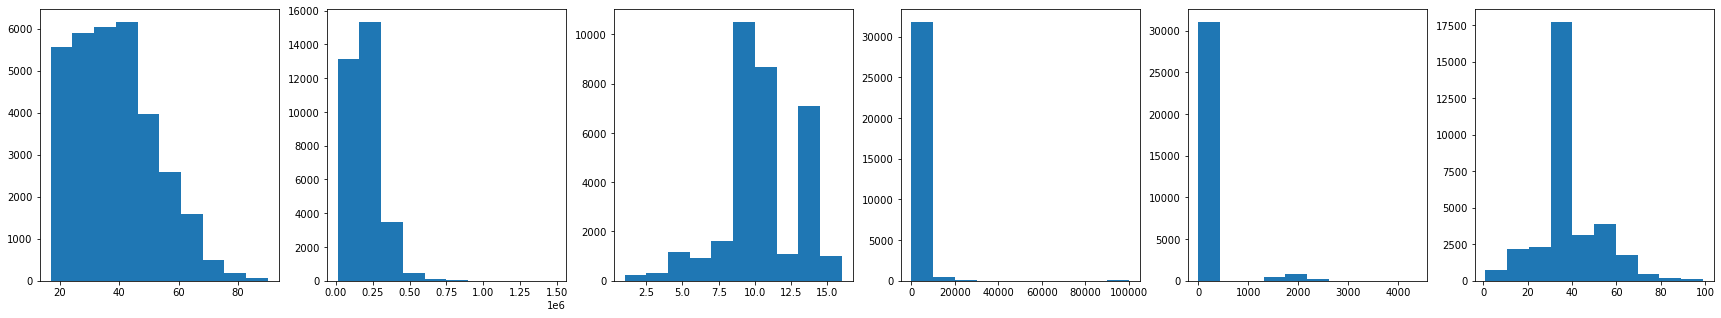

In [ ]:
fig, axs = plt.subplots(1, 6, figsize = (30,5))
axs[0].hist(training_set_df.F0)
axs[1].hist(training_set_df.F2)
axs[2].hist(training_set_df.F4)
axs[3].hist(training_set_df.F10)
axs[4].hist(training_set_df.F11)
axs[5].hist(training_set_df.F12)

# L'unico outlier dovuto a un errore nel dataset è quello in F2

Dai grafici precedenti si evince che nella feature F2 ci sono uno o più outlier, che verranno rimossi con la tecnica che usa *zscore*.

In [ ]:
# Individuazione e rimozione degli outlier (in F2) nel training set
z_scores = stats.zscore(training_set_df["F2"])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
training_set_df = training_set_df[filtered_entries]

training_set_df.head()

,F0,F2,F4,F10,F11,F12,K1,K2,K3,K4,...,Hong,Cambodia,Caribbean,Thailand,Laos,Yugoslavia,Honduras,Hungary,Scotland,Netherlands
0,39.0,77516.0,13.0,2174.0,0.0,40.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50.0,83311.0,13.0,0.0,0.0,13.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38.0,215646.0,9.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,53.0,234721.0,7.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,28.0,338409.0,13.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:ylabel='Frequency'>

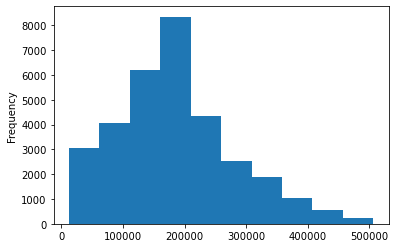

In [ ]:
# Verifica rimozione outlier
training_set_df["F2"].plot.hist()

(array([ 171.,  523.,  524., 4140.,  744.,  951.,  399.,  112.,   47.,
          40.]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <BarContainer object of 10 artists>)

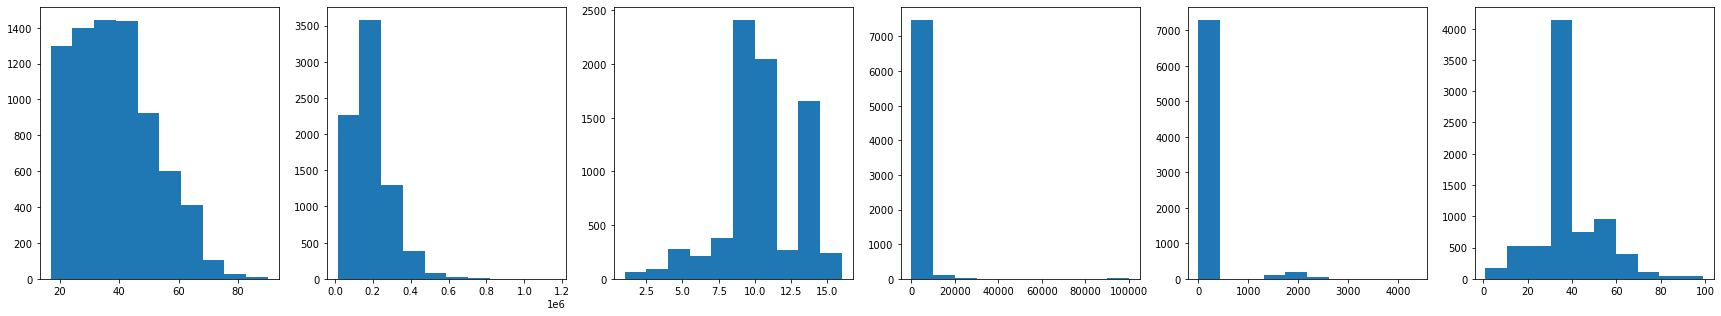

In [ ]:
fig, axs = plt.subplots(1, 6, figsize = (30,5))
axs[0].hist(test_set_df.F0)
axs[1].hist(test_set_df.F2)
axs[2].hist(test_set_df.F4)
axs[3].hist(test_set_df.F10)
axs[4].hist(test_set_df.F11)
axs[5].hist(test_set_df.F12)

# L'unico outlier dovuto a un errore nel dataset è quello in F2

In [ ]:
# Individuazione e rimozione degli outlier (in F2) nel test set
z_scores = stats.zscore(test_set_df["F2"])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
test_set_df = test_set_df[filtered_entries]

test_set_df.head()

,F0,F2,F4,F10,F11,F12,K1,K2,K3,K4,...,Ireland,Hong,Cambodia,Caribbean,Thailand,Laos,Yugoslavia,Honduras,Hungary,Scotland
0,55.0,171328.0,10.0,0.0,0.0,35.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,64.0,144182.0,9.0,0.0,0.0,23.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,34.0,102858.0,9.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,19.0,199495.0,10.0,0.0,0.0,60.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,58.0,209438.0,10.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:ylabel='Frequency'>

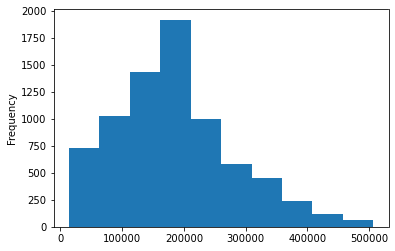

In [ ]:
# Verifica rimozione outlier
test_set_df["F2"].plot.hist()

#### Bilanciamento
Dopo aver illustrato la proporzione di 1 e 0 nel target (di training e test set) con degli istogrammi, si è ritenuto opportuno effettuare un bilanciamento.

Quest'ultimo è stato realizzato con la tecnica di oversampling SMOTE.

array([[<AxesSubplot:title={'center':'Y'}>]], dtype=object)

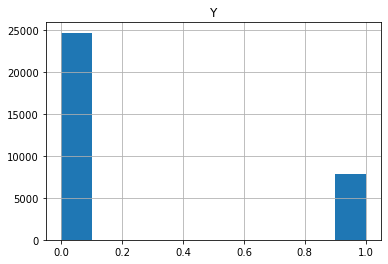

In [ ]:
# Controllo bilanciamento y_train
y_training_df = pd.DataFrame(y_train, columns = ["Y"])
y_training_df.hist()

array([[<AxesSubplot:title={'center':'Y'}>]], dtype=object)

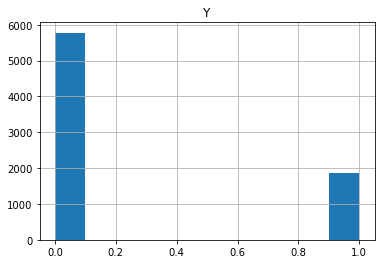

In [ ]:
# Controllo bilanciamento y_test
y_test_df = pd.DataFrame(y_test, columns = ["Y"])
y_test_df.hist()

SMOTE (Synthetic Minority Oversampling Technique): serve ad aumentare la dimensione della classe minoritaria creando dati sintetici, creati in base a formule e algoritmi di clustering sui dati presenti.

In [ ]:
# y_train e y_test sono sbilanciate
# SMOTE
smote = SMOTE(random_state = 0, sampling_strategy = 'not majority', k_neighbors = 10, n_jobs = -1)
x_train_notnan, y_train = smote.fit_resample(x_train_notnan, y_train)
print(x_train_notnan.shape, y_train.shape)
print(x_train_notnan)

smote = SMOTE(random_state = 0, sampling_strategy = 'not majority', k_neighbors = 10, n_jobs = -1)
x_test_notnan, y_test = smote.fit_resample(x_test_notnan, y_test)
print(x_test_notnan.shape, y_test.shape)
print(x_test_notnan)

(49440, 14) (49440,)
[[3.90000000e+01 0.00000000e+00 7.75160000e+04 ... 0.00000000e+00
  4.00000000e+01 0.00000000e+00]
 [5.00000000e+01 1.00000000e+00 8.33110000e+04 ... 0.00000000e+00
  1.30000000e+01 0.00000000e+00]
 [3.80000000e+01 2.00000000e+00 2.15646000e+05 ... 0.00000000e+00
  4.00000000e+01 0.00000000e+00]
 ...
 [4.10276260e+01 0.00000000e+00 2.93493454e+05 ... 0.00000000e+00
  4.02762597e+01 0.00000000e+00]
 [3.96186317e+01 2.00000000e+00 1.51182880e+05 ... 0.00000000e+00
  4.18139599e+01 0.00000000e+00]
 [4.54011576e+01 3.52228653e+00 1.86365752e+05 ... 1.91537496e+03
  4.71657020e+01 0.00000000e+00]]
(11558, 14) (11558,)
[[5.50000000e+01 4.00000000e+00 1.71328000e+05 ... 0.00000000e+00
  3.50000000e+01 0.00000000e+00]
 [6.40000000e+01 2.00000000e+00 1.44182000e+05 ... 0.00000000e+00
  2.30000000e+01 0.00000000e+00]
 [3.40000000e+01 2.00000000e+00 1.02858000e+05 ... 0.00000000e+00
  4.00000000e+01 0.00000000e+00]
 ...
 [4.15764684e+01 1.68403346e+00 1.16700213e+05 ... 0.000

array([[<AxesSubplot:title={'center':'Y'}>]], dtype=object)

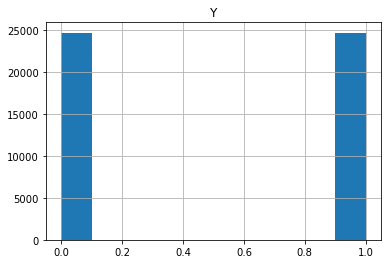

In [ ]:
# Verifica bilanciamento y_train
y_training_df = pd.DataFrame(y_train, columns = ["Y"])
y_training_df.hist()

array([[<AxesSubplot:title={'center':'Y'}>]], dtype=object)

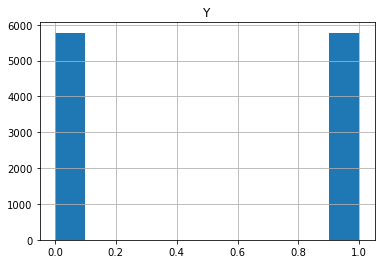

In [ ]:
# Verifica bilanciamento y_test
y_test_df = pd.DataFrame(y_test, columns = ["Y"])
y_test_df.hist()

#### Scaling

Scalare i dati serve a migliorare il comportamento degli algoritmi di learning, dal momento che i dati potrebbero avere valori di tipi diversi tra loro. Valori troppo grandi possono comportarsi da outlier e stravolgere il funzionamento di un algoritmo.

Per scalare i dati si utilizza la normalizzazione attraverso lo *StandardScaler* offerto da sklearn, che normalizza le feature rimuovendo la media e scalando a varianza unitaria.

Il valore normalizzato di x è calcolato come: $$x = \frac{z-u}{S}$$

*StandardScaler* è stato preferito agli altri scaler poiché computazionalmente conveniente, oltre al fatto che i risultati erano pressoché identici.

In [ ]:
# Scaling con StandardScaler

print("StandardScaler")
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_notnan)
x_test_scaled = scaler.transform(x_test_notnan)

print("Media distribuzione di partenza: {}".format(np.mean(x_train_notnan, axis=0)))
print("Media distribuzione scalata: {}".format(np.mean(x_train_scaled, axis=0)))

print("Deviazione standard distribuzione di partenza: {}".format(np.std(x_train_notnan, axis=0)))
print("Deviazione standard distribuzione scalata: {}".format(np.std(x_train_scaled, axis=0)))

print("Media distribuzione di partenza: {}".format(np.mean(x_test_notnan, axis=0)))
print("Media distribuzione scalata: {}".format(np.mean(x_test_scaled, axis=0)))

print("Deviazione standard distribuzione di partenza: {}".format(np.std(x_test_notnan, axis=0)))
print("Deviazione standard distribuzione scalata: {}".format(np.std(x_test_scaled, axis=0)))

StandardScaler
Media distribuzione di partenza: [4.05058644e+01 2.15981411e+00 1.89219794e+05 3.32739817e+00
 1.05989050e+01 1.08401463e+00 4.07560538e+00 1.39223053e+00
 1.95716200e-01 2.66488529e-01 2.10958176e+03 1.17858002e+02
 4.21353012e+01 8.24880186e-01]
Media distribuzione scalata: [ 2.93562819e-15 -3.03368711e-14  1.31982600e-14 -1.74785573e-15
  1.20711469e-14  3.08248011e-16 -1.64516683e-15 -2.50984104e-14
 -1.31620173e-14  5.40420684e-14  5.10934045e-14 -4.31587614e-14
  2.43042450e-14 -2.60129364e-15]
Deviazione standard distribuzione di partenza: [1.24375785e+01 9.19870763e-01 1.04045777e+05 3.21475896e+00
 2.48640751e+00 1.06767085e+00 2.77548633e+00 1.23350051e+00
 5.64849280e-01 4.26366328e-01 1.07732380e+04 4.61559090e+02
 1.15434068e+01 3.67831386e+00]
Deviazione standard distribuzione scalata: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Media distribuzione di partenza: [4.03721501e+01 2.15475995e+00 1.89226575e+05 3.42082556e+00
 1.06033209e+01 1.09401072e+00 4.064

### Classificazione

#### AdaBoost

In questa implementazione di Adaboost abbiamo usato la funzione *GridSearchCV*, che prende in input delle liste di parametri ed effettua una k-fold cross validation per l'addestramento con ogni singola combinazione dei parametri passati, per poi comunicare il risultato migliore e con quale configurazione di iperaparametri è stato ottenuto.

In questo caso è stata usata una 2-times 5-fold cross validation.

In particolare i parametri immessi in *GridSearchCV* sono: una lista del numero di stimatori, una lista di learning rate da utilizzare, il numero di fold in cui splittare il training set e il numero di ripetizioni da effettuare.

Infine, l'*AdaBoostClassifier* utilizzato è quello di default, ovvero un decision tree con profondità 1 (uno stump).

Il valore stampato indica l'accuracy della predizione (in percentuale) sul training set. Insieme a esso viene mostrata la matrice di confusione con i valori di TP, TN, FP, FN.

Best: 0.909466 using {'learning_rate': 1, 'n_estimators': 1000}
0.9148641633500606


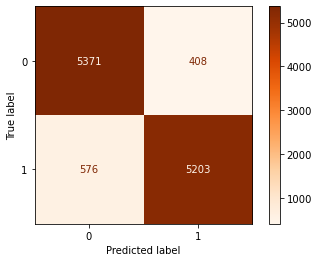

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

classifierADA = AdaBoostClassifier()

grid = dict()
grid['n_estimators'] = [40, 200, 1000]
grid['learning_rate'] = [.001, .01, .1, 1]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 1)

# define the grid search procedure
grid_search = GridSearchCV(estimator = classifierADA, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')

# execute the grid search
grid_fit = grid_search.fit(x_train_scaled, y_train)

# execute the grid search
y_pred_rf = grid_search.predict(x_test_scaled)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_fit.best_score_ , grid_fit.best_params_))

CM_ADA = confusion_matrix(y_test, y_pred_rf)
PercADA = (CM_ADA[0,0]+CM_ADA[1,1])/CM_ADA.sum()

cmd = ConfusionMatrixDisplay(CM_ADA)
cmd.plot(cmap = "Oranges")

print(PercADA)